## LightGBMのテンプレート

テーブルデータの解析でよく利用されるLightGBMですが、最近よく利用することになったので、一度テンプレートとしてまとめおきます。

(2022/2/5更新: とある優秀なDataScientistの方からShapによる特徴量の解析方法を教えてもらったので、テンプレートに追加しておきます)

- データの取得
- モデルの作成
- Cross Validation
- TESTの評価
- Shapによる解析

### github
- githubのjupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/article/library/python/014/014_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/article/library/python/014/014_nb.ipynb)

### 筆者の環境

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G9323


In [2]:
!python -V

Python 3.8.5


In [3]:
import sys
sys.executable

'/Users/hiroshi.wayama/anaconda3/envs/lgbm2/bin/python'

## ライブラリの読み込み

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import time
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import japanize_matplotlib
import snap

import lightgbm as lgb

from sklearn import datasets
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_california_housing
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')
sns.set(font='IPAexGothic')

import warnings
warnings.filterwarnings('ignore')

### データの読み込み

読み込むデータとしてはこれまでボストンの住宅価格のデータセットを利用していましたが、最近depricatedになったので、新しく加わったカリフォルニアの住宅価格を利用する。

In [5]:
california_housing = fetch_california_housing(as_frame=True)
df = pd.DataFrame(california_housing['data'], columns=california_housing.feature_names)
df_target = pd.Series(california_housing['target'])

# template
# 説明変数の設定
X_data = df
# 目的変数の設定
Y_data = df_target

In [6]:
X_data.shape, Y_data.shape

((20640, 8), (20640,))

In [7]:
X_data.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25

In [8]:
Y_data.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

### 定数

ランダム値を固定するためのシード値や諸々の定数を設定。

In [9]:
# const
seed = 123
random_state = 123
n_splits=5
test_size=0.2

### シードの固定関数

一括でシードを設定するための関数。

In [10]:
def set_seed(seed=seed):
  os.environ["PYTHONHASHSEED"] = str(seed) 
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  # GPUパフォーマンスが低下する場合はコメントアウト
  torch.backends.cudnn.deterministic = True
  torch.use_deterministic_algorithms = True

### データの分割
TrainとTest用のデータに分割します。

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=test_size, random_state=random_state)

In [12]:
X_train.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
9950  4.5694      28.0  6.219512   1.030488       504.0  3.073171     38.38   
3547  5.6392      18.0  5.951644   1.034816      3010.0  2.911025     34.26   
4448  1.7292      47.0  3.628032   1.032345      1452.0  3.913747     34.07   
6984  4.6226      36.0  5.126238   0.985149       988.0  2.445545     33.96   
4432  2.4375      49.0  4.024390   0.942073      1405.0  4.283537     34.08   

      Longitude  
9950    -122.33  
3547    -118.60  
4448    -118.21  
6984    -118.02  
4432    -118.20

In [13]:
X_test.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
19121  3.7917      40.0  4.959799   1.030151      1039.0  2.610553     38.24   
20019  4.0217       9.0  5.804577   1.000000      1749.0  3.079225     36.09   
15104  4.0882      12.0  5.360360   1.070571      3321.0  4.986486     32.85   
3720   2.2377      27.0  3.376582   1.023207      3403.0  3.589662     34.20   
8938   4.4211      41.0  5.656904   1.165272      1047.0  2.190377     34.01   

       Longitude  
19121    -122.64  
20019    -119.05  
15104    -116.98  
3720     -118.42  
8938     -118.47

In [14]:
Y_train.head()

9950    2.875
3547    2.715
4448    1.917
6984    2.197
4432    1.140
Name: MedHouseVal, dtype: float64

In [15]:
Y_test.head()

19121    1.516
20019    0.992
15104    1.345
3720     2.317
8938     4.629
Name: MedHouseVal, dtype: float64

## Trainデータを利用したモデルの作成

### Cross Validation

Trainデータに対して交差検証を行う。交差検証(Cross Validation)は、データ全体を分割し、一部を用いてモデルを作成し、残りのデータでバリデーションを行う方法である。データ全体をK分割し、K-1個を訓練用データ、残りの一つを妥当性検証用のデータに利用する、K-Fold Cross Validationを行う。

各Foldデータに対して、損失関数の推移とモデルから計算された予測値と真値の散布図も描画する。

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[828]	Train's rmse: 0.173173	Val's rmse: 0.448933


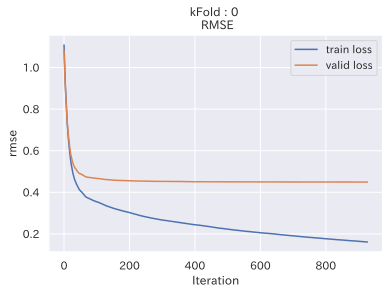

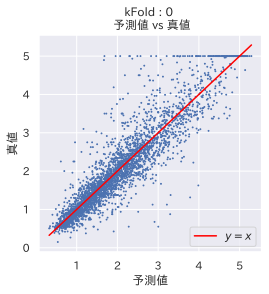

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[494]	Train's rmse: 0.219891	Val's rmse: 0.453579


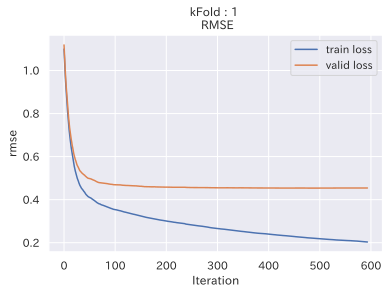

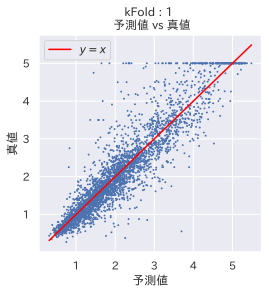

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[793]	Train's rmse: 0.172299	Val's rmse: 0.467271


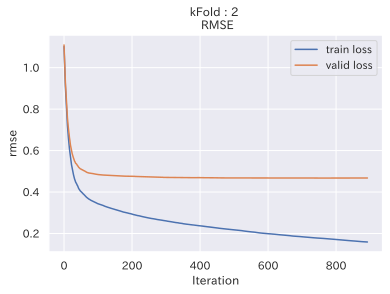

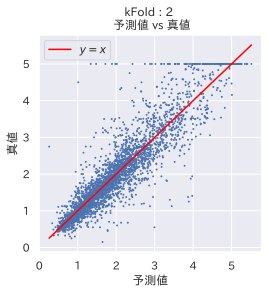

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	Train's rmse: 0.246327	Val's rmse: 0.447831


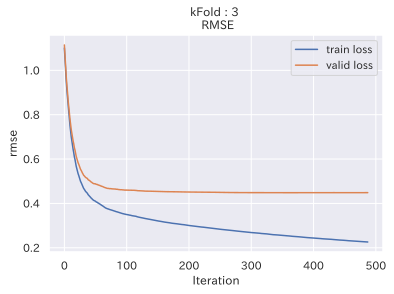

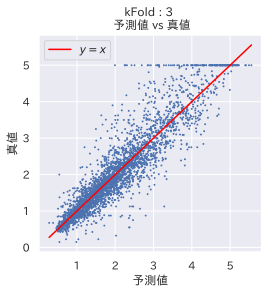

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[462]	Train's rmse: 0.233192	Val's rmse: 0.423386


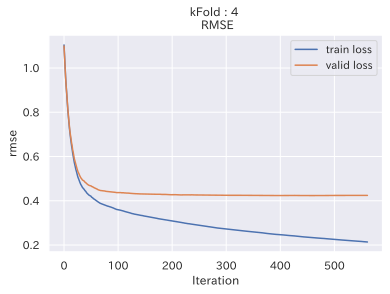

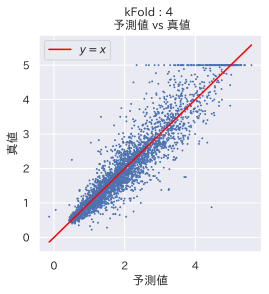

CPU times: user 1min 18s, sys: 4.58 s, total: 1min 22s
Wall time: 16.8 s


In [16]:
%%time

params = {
  'random_state': random_state,
  'objective': 'regression',
  'boosting_type': 'gbdt',
  'metric': {'rmse'},
  'verbosity': -1,
  'bagging_freq': 1,
  'feature_fraction': 0.8,
  'max_depth': 8,
  'min_data_in_leaf': 25,
  'num_leaves': 256,
  'learning_rate': 0.07,
  'lambda_l1': 0.2,
  'lambda_l2': 0.5,
}

model_list = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for _index, (_train_index, _val_index) in enumerate(kf.split(X_train, Y_train)):
 
   _X_train = X_train.iloc[_train_index]
   _Y_train = Y_train.iloc[_train_index]
 
   _X_val = X_train.iloc[_val_index]
   _Y_val = Y_train.iloc[_val_index]
 
   lgb_train = lgb.Dataset(_X_train, _Y_train)
   lgb_val = lgb.Dataset(_X_val, _Y_val, reference=lgb_train)
  
   lgb_results = {}   

   model = lgb.train(
     params, 
     train_set=lgb_train, 
     valid_sets=[lgb_train, lgb_val],
     verbose_eval=-1,
     num_boost_round=1000,
     early_stopping_rounds=100,
     valid_names=['Train', 'Val'],
     evals_result=lgb_results
   )

  # CVの各モデルの保存
   model_list.append(model)

   # 損失関数の推移
   loss_train = lgb_results['Train']['rmse']
   loss_val = lgb_results['Val']['rmse']
   best_iteration = model.best_iteration
    
   plt.figure()
   plt.xlabel('Iteration')
   plt.ylabel('rmse')
   plt.plot(loss_train, label='train loss')
   plt.plot(loss_val, label='valid loss')
   plt.title('kFold : {} \n RMSE'.format(_index))
   plt.legend()
   plt.show()
  
  # 散布図
   plt.figure(figsize=(4,4))
   y_val = model.predict(_X_val, num_iteration=model.best_iteration)
   plt.plot(y_val, y_val, color = 'red', label = '$y=x$')
   plt.scatter(y_val,_Y_val, s=1)
   plt.xlabel('予測値')
   plt.ylabel('真値')
   plt.title('kFold : {} \n 予測値 vs 真値'.format(_index))
   plt.legend()
   plt.show()

### 特徴量の重要度を可視化

modelに保存されているimportanceを可視化。こちらのサイトを参考。

- https://www.sairablog.com/article/lightgbm-sklearn-kaggle-classification.html 

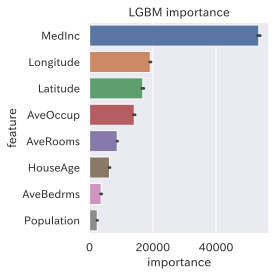

In [17]:
feature_importances = pd.DataFrame()

for fold, model in enumerate(model_list):

    tmp = pd.DataFrame()
    tmp['feature'] = model.feature_name()
    tmp['importance'] = model.feature_importance(importance_type='gain')
    tmp['fold'] = fold

    feature_importances = feature_importances.append(tmp)

order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)

plt.figure(figsize=(4, 4))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('LGBM importance')
plt.tight_layout()
plt.show()

## TESTデータを用いた推論

各Foldで生成されたモデルに対して、TESTデータを利用して、予測する。予測値は各Foldの平均とする。

In [18]:
_test_score_array = np.zeros(len(X_test))

for model in model_list:
  y_pred = model.predict(X_test, num_iteration=model.best_iteration)
  
  _test_score_array += y_pred / n_splits

_test_score_array

array([2.08291787, 0.88297742, 1.44321429, ..., 0.82898221, 2.08941514,
       3.45456004])

### TEST結果の特徴量の重要度を可視化

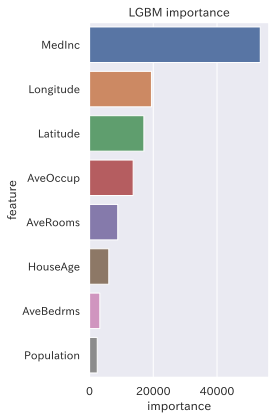

In [19]:
# 特徴量重要度を保存する dataframe を用意
# https://www.sairablog.com/article/lightgbm-sklearn-kaggle-classification.html から抜粋
top_feature_num = 10
feature_importances = pd.DataFrame({
  'feature' : model.feature_name(),
  'importance': model.feature_importance(importance_type='gain'),
})

order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:top_feature_num]

plt.figure(figsize=(4, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('LGBM importance')
plt.tight_layout()
plt.show()

## Shapによる解析

最近まで知らなかったのだが、Shapという解析方法を教えてもらったので早速テンプレートに追加する。

Shapを利用して、特徴量が結果に対してどのような影響を与えたか定量的に求める事ができる。
モデルの生成理由などを説明するためによく利用される。

In [20]:
import shap

shap.initjs()
explainer = shap.Explainer(model, _X_train)
shap_values = explainer(_X_train, check_additivity=False)

100%|===================| 13179/13210 [05:39<00:00]        

### summary plot

summaryで、特徴量毎にどの程度影響を与えたか可視化することができる。

目的変数に対して、青が正の影響を、赤が負の影響を与えた事を表している。

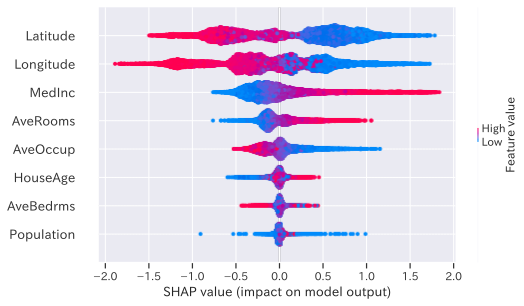

In [21]:
shap.summary_plot(shap_values, _X_train)

また、以下の様にして、正と負のトータルとしてどのような影響を与えたか知ることができる。

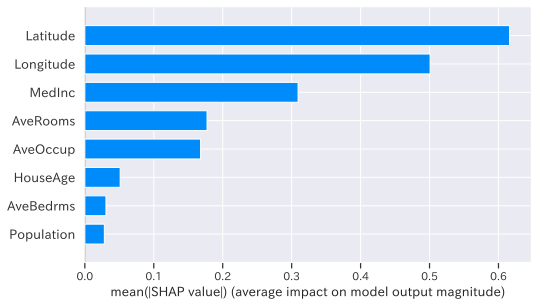

In [22]:
shap.summary_plot(shap_values, _X_train, plot_type="bar")

### waterfallによる解析

各データ一つ一つに対して、特徴量の影響を可視化することができる。

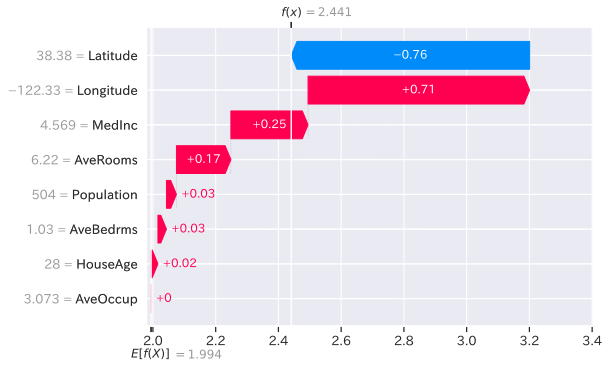

In [23]:
shap.plots.waterfall(shap_values[0], max_display=20)

In [24]:
shap_values.shape

(13210, 8)

In [25]:
Y_val = model.predict(_X_train, num_iteration=model.best_iteration)
df_result = pd.DataFrame({
  'index': _X_train.index.tolist(),
  'train_score': Y_val,
})

上位のデータと下位のデータを比較し、どの特徴量が効果があるか確認する。

In [26]:
top = df_result.sort_values(by='train_score', ascending=False).index.tolist()
bottom = df_result.sort_values(by='train_score').index.tolist()

### 上位5件を表示

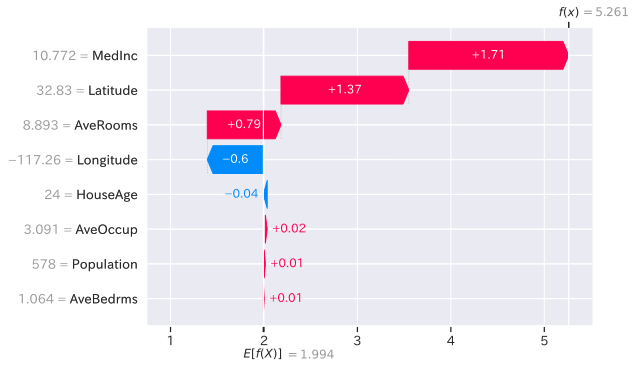

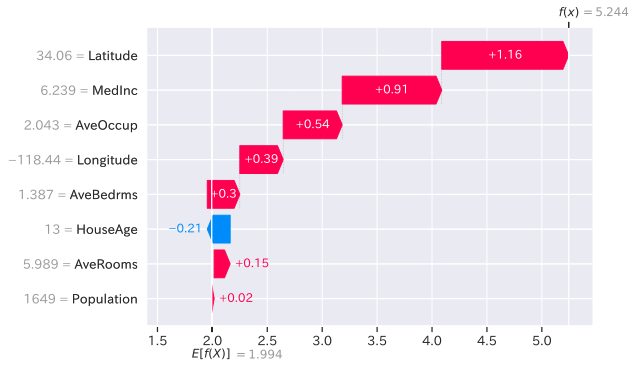

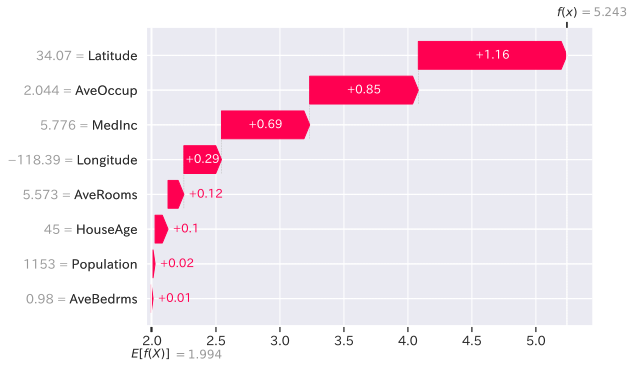

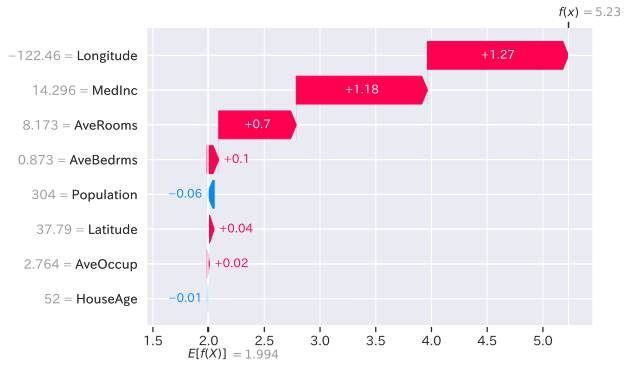

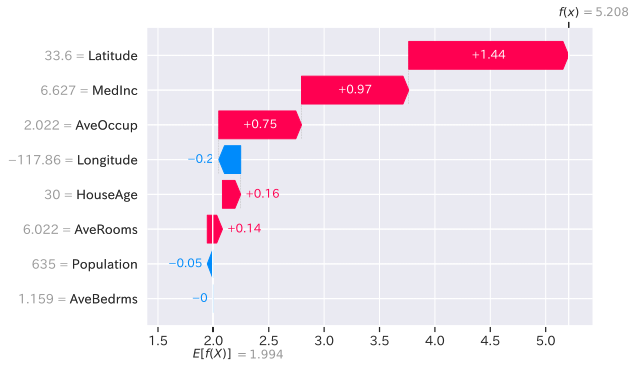

In [27]:
for i in top[:5]:
  shap.plots.waterfall(shap_values[i], max_display=20)

### 下位の5件を表示

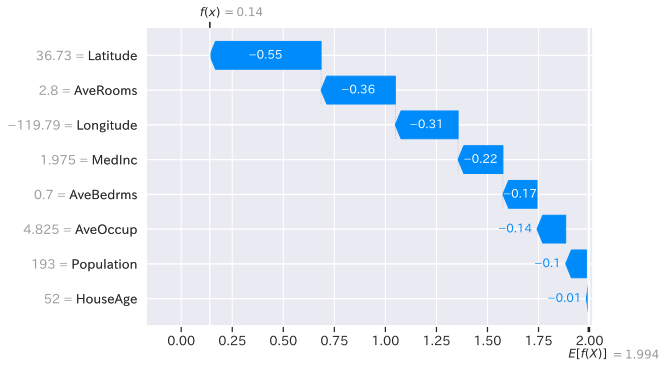

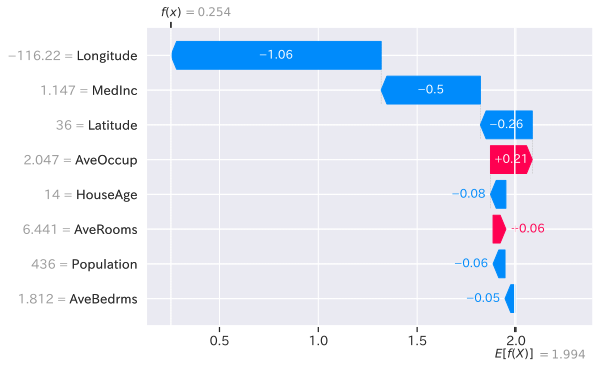

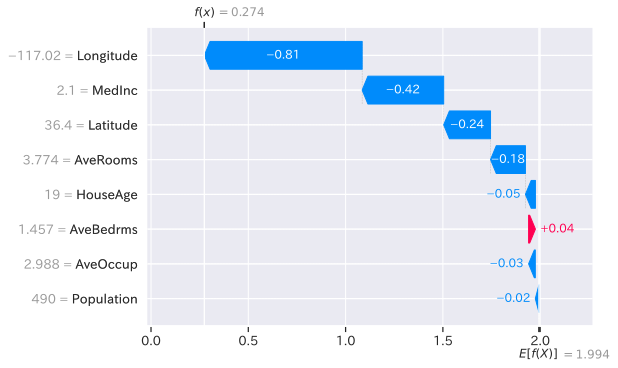

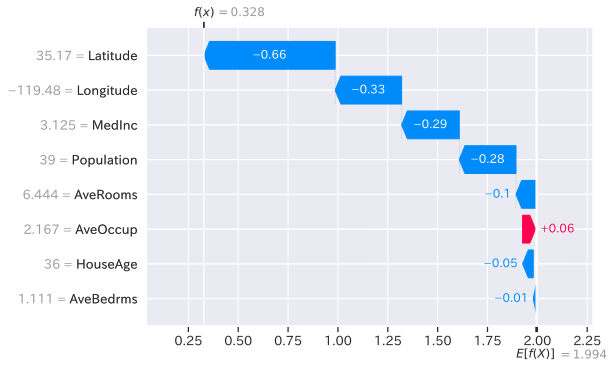

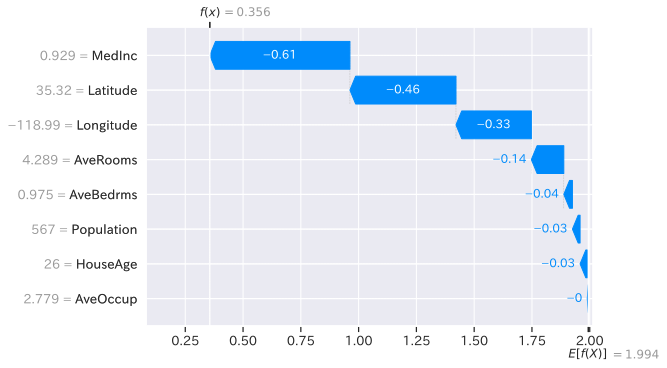

In [28]:
for i in bottom[:5]:
  shap.plots.waterfall(shap_values[i], max_display=20)

### 特徴量の依存性確認

それぞれの特徴量とSHAP値の相関関係を可視化することができる。

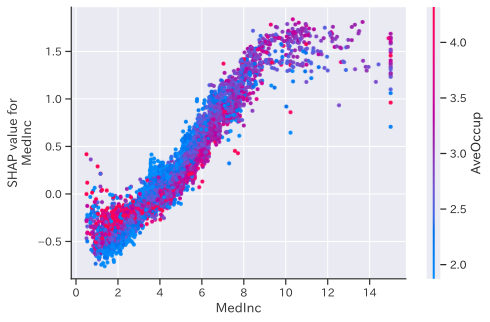

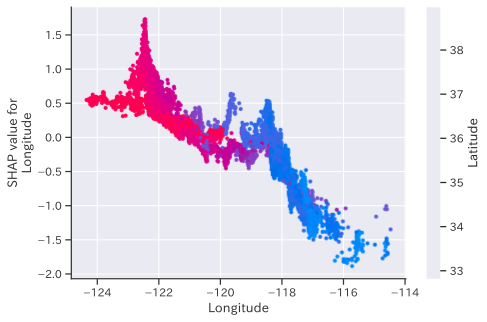

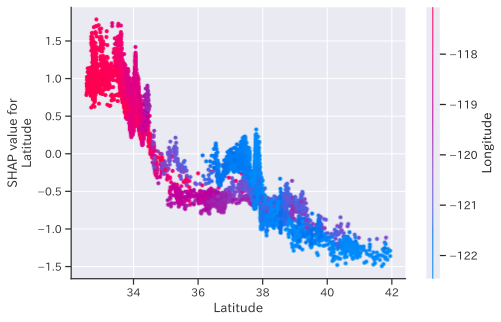

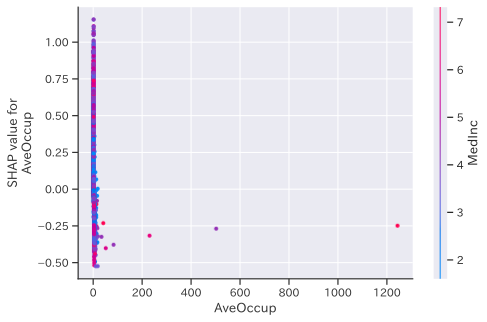

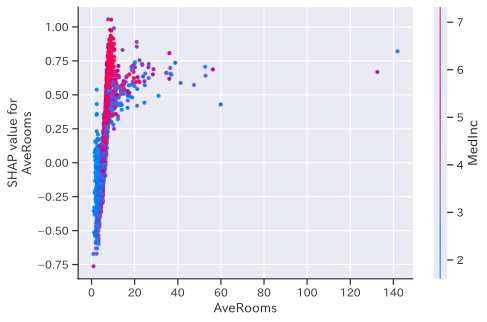

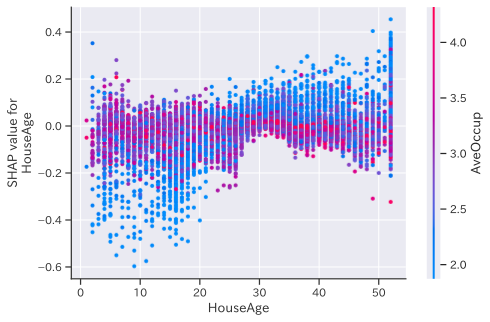

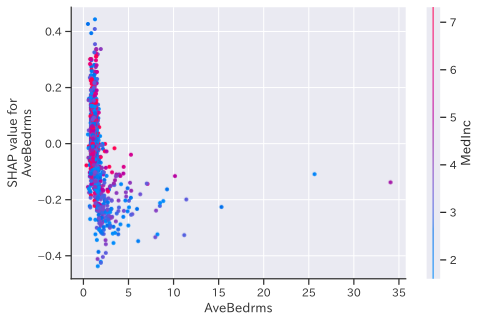

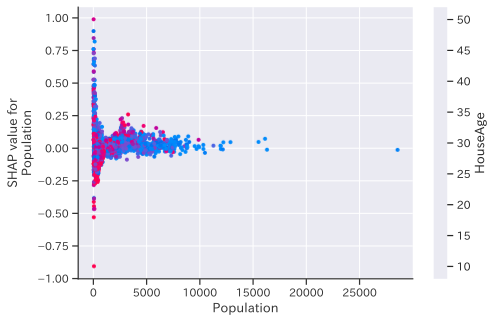

In [29]:
feature_importances = pd.DataFrame({
  'feature' : model.feature_name(),
  'importance': model.feature_importance(importance_type='gain'),
})
feature_list = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
for feature in feature_list:
  shap.dependence_plot(feature, shap_values.values, _X_train)

回帰問題に対してLightGBMを利用する際のテンプレートを用意した。
今後も追記する項目が増えた場合は更新する。

## 参考記事

- https://www.sairablog.com/article/lightgbm-sklearn-kaggle-classification.html